In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 85.60%
Success Probability Vector:
tensor([9.6159e-01, 1.9331e-03, 1.2049e-02, 2.5051e-03, 2.3616e-03, 4.9744e-04,
        1.4415e-03, 1.5702e-03, 1.2903e-02, 3.1494e-03], device='cuda:0')
Class 2 - Accuracy: 91.90%
Success Probability Vector:
tensor([3.0343e-03, 9.6566e-01, 6.1120e-04, 9.8081e-04, 4.2004e-04, 3.7149e-04,
        4.8418e-04, 6.1977e-04, 5.9375e-03, 2.1879e-02], device='cuda:0')
Class 3 - Accuracy: 64.60%
Success Probability Vector:
tensor([1.7182e-02, 9.5494e-04, 9.2181e-01, 1.3961e-02, 1.6620e-02, 8.6877e-03,
        1.4209e-02, 4.7929e-03, 1.0192e-03, 7.6007e-04], device='cuda:0')
Class 4 - Accuracy: 67.80%
Success Probability Vector:
tensor([0.0042, 0.0019, 0.0094, 0.9014, 0.0128, 0.0444, 0.0156, 0.0066, 0.0019,
        0.0017], device='cuda:0')
Class 5 - Accuracy: 80.20%
Success Probability Vector:
tensor([2.6719e-03, 4.9526e-04, 1.1413e-02, 1.1751e-02, 9.4248e-01, 6.765

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 1.0, Variance = 1.5582077389996417e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 1 (Failed): Mean = 1.0, Variance = 1.3167400333193588e-15, Min = 0.9999999403953552, Max = 1.0000001192092896
Class 2 (Successful): Mean = 1.0, Variance = 1.424181503997357e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Failed): Mean = 1.0, Variance = 9.769962828459614e-16, Min = 0.9999999403953552, Max = 1.0000001192092896
Class 3 (Successful): Mean = 1.0, Variance = 1.2723672594653766e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Failed): Mean = 1.0, Variance = 1.2580430852943592e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Successful): Mean = 1.0, Variance = 1.5113464882257448e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Failed): Mean = 1.0, Variance = 1.2727790233568606e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 5 (Successful): Mean = 1.0, Variance = 1.49914762559

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[66.0, 82.0, 81.18811881188118, 90.9090909090909, 77.0, 84.15841584158416, 83.16831683168317, 79.0, 73.73737373737374, 81.18811881188118, 77.0, 79.0, 84.15841584158416, 78.0, 90.0, 78.0, 76.0, 84.84848484848484, 75.0, 82.82828282828282, 77.0, 80.0, 83.16831683168317, 65.0, 83.83838383838383, 85.14851485148515, 71.71717171717172, 83.33333333333333, 76.0, 88.23529411764706, 90.9090909090909, 75.0, 76.0, 76.0, 78.0, 83.0, 79.0, 74.0, 76.76767676767676, 77.22772277227723, 85.14851485148515, 68.0, 76.0, 71.2871287128713, 75.49019607843137, 72.72727272727273, 74.74747474747475, 71.71717171717172, 69.0, 82.82828282828282, 81.81818181818181, 82.82828282828282, 77.0, 75.75757575757575, 67.0, 81.0, 74.0, 73.73737373737374, 67.32673267326733, 89.8989898989899, 86.13861386138613, 74.0, 82.0, 71.71717171717172, 89.8989898989899, 92.0, 84.15841584158416, 73.73737373737374, 78.78787878787878, 91.0, 92.0, 81.0, 84.313725490196

In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {3: 166, 4: 167, 9: 167}, 1: {1: 167, 3: 167, 4: 166}, 2: {3: 167, 6: 167, 7: 166}, 3: {1: 167, 8: 166, 9: 167}, 4: {0: 167, 2: 167, 8: 167}, 5: {1: 167, 3: 167, 7: 167}, 6: {2: 166, 8: 167, 9: 167}, 7: {0: 167, 3: 167, 7: 167}, 8: {2: 166, 6: 167, 9: 166}, 9: {4: 167, 6: 166, 9: 167}, 10: {3: 167, 4: 167, 8: 166}, 11: {7: 333, 8: 167}, 12: {5: 166, 6: 334}, 13: {0: 167, 2: 167, 3: 166}, 14: {0: 167, 1: 334}, 15: {2: 166, 8: 167, 9: 166}, 16: {0: 167, 3: 167, 4: 167}, 17: {1: 333, 2: 167}, 18: {1: 167, 2: 166, 8: 167}, 19: {1: 167, 3: 167, 5: 167}, 20: {4: 167, 5: 166, 9: 166}, 21: {4: 166, 6: 334}, 22: {1: 167, 2: 167, 7: 167}, 23: {3: 167, 5: 334}, 24: {0: 166, 2: 167, 8: 167}, 25: {0: 333, 8: 167}, 26: {5: 167, 6: 167, 9: 167}, 27: {0: 167, 6: 167, 7: 167}, 28: {0: 166, 5: 167, 9: 166}, 29: {0: 166, 7: 167, 9: 166}, 30: {0: 167, 1: 332}, 31: {5: 167, 9: 334}, 32: {2: 167, 7: 332}, 33: {2: 167, 6: 167, 9: 166}, 34: {0: 167, 3

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {3: 33, 4: 33, 9: 34}, 1: {1: 33, 3: 34, 4: 33}, 2: {3: 34, 6: 34, 7: 33}, 3: {1: 33, 8: 33, 9: 33}, 4: {0: 33, 2: 34, 8: 33}, 5: {1: 34, 3: 34, 7: 33}, 6: {2: 34, 8: 33, 9: 34}, 7: {0: 33, 3: 34, 7: 33}, 8: {2: 33, 6: 33, 9: 33}, 9: {4: 34, 6: 33, 9: 34}, 10: {3: 34, 4: 33, 8: 33}, 11: {7: 66, 8: 34}, 12: {5: 34, 6: 67}, 13: {0: 34, 2: 33, 3: 33}, 14: {0: 33, 1: 67}, 15: {2: 33, 8: 34, 9: 33}, 16: {0: 34, 3: 33, 4: 33}, 17: {1: 66, 2: 33}, 18: {1: 33, 2: 33, 8: 34}, 19: {1: 33, 3: 33, 5: 33}, 20: {4: 33, 5: 33, 9: 34}, 21: {4: 33, 6: 67}, 22: {1: 34, 2: 34, 7: 33}, 23: {3: 33, 5: 67}, 24: {0: 33, 2: 33, 8: 33}, 25: {0: 67, 8: 34}, 26: {5: 33, 6: 33, 9: 33}, 27: {0: 34, 6: 34, 7: 34}, 28: {0: 33, 5: 34, 9: 33}, 29: {0: 34, 7: 34, 9: 34}, 30: {0: 33, 1: 66}, 31: {5: 33, 9: 67}, 32: {2: 33, 7: 67}, 33: {2: 34, 6: 33, 9: 33}, 34: {0: 33, 3: 33, 8: 34}, 35: {6: 67, 7: 33}, 36: {2: 33, 6: 34, 7: 33}, 37: {0: 34, 3: 33, 5: 33}, 38: {2

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.1226, -0.1695,  0.0843,  0.0917,  0.0814,  0.0184, -0.1037, -0.0885,
        -0.0836,  0.0662], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([60.8296, 67.7241, 60.6940, 59.0294, 63.3524, 60.2708, 69.0079, 65.4187,
        69.3878, 67.6714], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000, -0.0835, -0.0752, -0.1667, -0.0379, -0.1839, -0.2237, -0.1410,
          0.0491, -0.1095],
        [-0.0835,  1.0000, -0.1659, -0.1871, -0.1738, -0.2082, -0.1868, -0.0914,
          0.0129,  0.0443],
        [-0.0752, -0.1659,  1.0000, -0.1161, -0.1059, -0.0923, -0.0285, -0.1060,
         -0.1175, -0.1511],
        [-0.1667, -0.1871, -0.1161,  1.0000,  0.0210,  0.0431, -0.0711, -0.1071,
         -0.2265, -0.1352],
        [-0.0379, -0.1738, -0.1059,  0.0210,  1.0000, -0.1771, -0.0575, -0.0126,
         -0.2217, -0.1

Weight norm of each class part of classifier
tensor([7.7993, 8.2295, 7.7906, 7.6831, 7.9594, 7.7634, 8.3071, 8.0882, 8.3299,
        8.2263], device='cuda:0', grad_fn=<SqrtBackward0>)


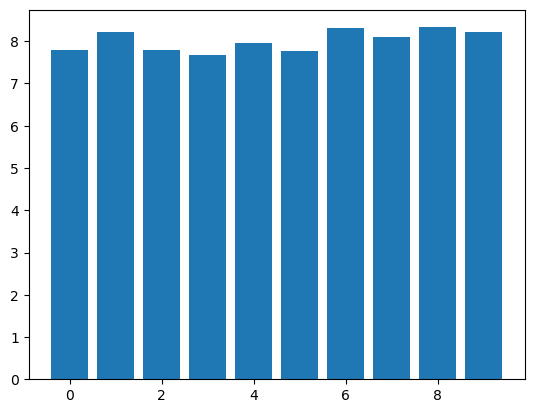

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

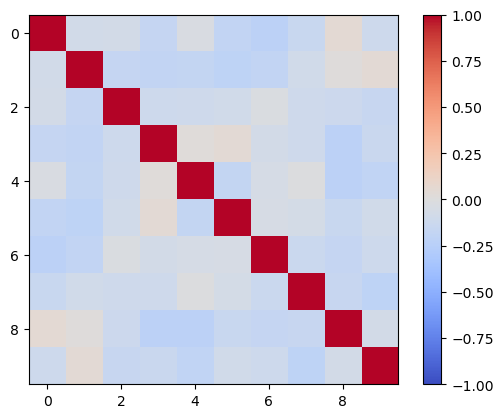

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.8884977, 1: 0.944067, 2: 0.7845625, 3: 0.8104524, 4: 0.86699426, 5: 0.8295259, 6: 0.89664596, 7: 0.8908329, 8: 0.9161001, 9: 0.8931229}
-------------------VAR-------------------
{0: 0.034773216, 1: 0.016915558, 2: 0.041072417, 3: 0.036778312, 4: 0.032346938, 5: 0.028916825, 6: 0.027877716, 7: 0.034764316, 8: 0.031026322, 9: 0.029096289}


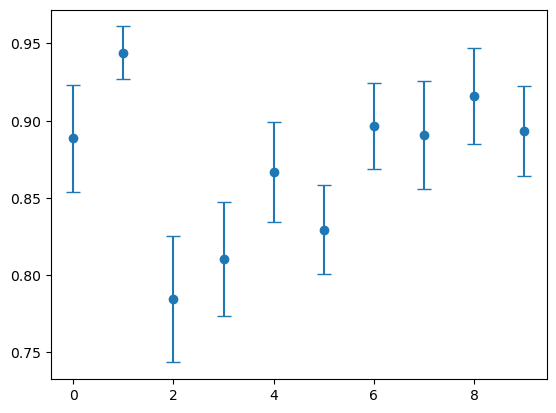

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [3]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([3.5337e-02, 1.7794e-03, 5.5423e-02, 4.1488e-03, 2.3123e-03, 1.0956e-04,
        9.6205e-02, 1.4164e-01, 6.2723e-02, 9.9986e-06, 1.4752e-02, 3.7891e-03,
        1.4871e-02, 1.7165e-02, 4.1829e-03, 5.4272e-03, 6.0661e-03, 1.2088e-02,
        6.6254e-03, 1.1964e-02, 5.2013e-03, 2.3081e-01, 7.5567e-03, 3.5484e-03,
        2.0715e-02, 6.4629e-04, 2.3884e-02, 3.9469e-02, 1.8859e-03, 1.2877e-02,
        6.4328e-03, 8.4745e-04, 2.5145e-02, 2.2291e-03, 1.6672e-03, 6.8347e-03,
        2.2008e-03, 1.7697e-03, 0.0000e+00, 1.3220e-03, 1.3881e-01, 3.1463e-06,
        4.3668e-03, 6.9757e-03, 1.2993e-02, 1.6203e-02, 2.0284e-03, 1.8780e-02,
        2.1231e-03, 1.0752e-02, 2.1038e-03, 4.3744e-03, 5.5617e-03, 1.0304e-02,
        1.5882e-01, 2.2652e-03, 2.6864e-03, 2.4773e-02, 5.1204e-02, 8.8094e-03,
        1.0845e-02, 1.9343e-02, 4.5170e-03, 7.4029e-03, 5.3653e-03, 2.2316e-02,
        0.0000e+00, 2.7608e-03, 4.9934e-

# Cosine Similarity of Centroid Vectors

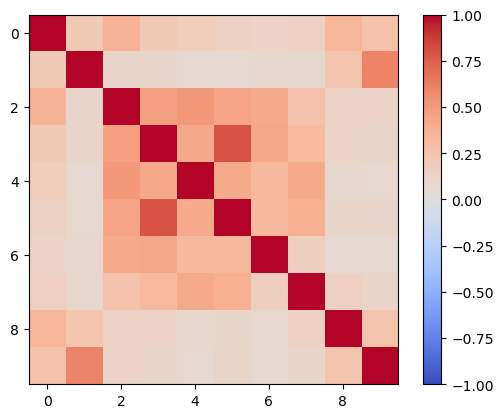

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.9999999  0.19879185 0.35360533 0.20160767 0.16608036 0.13641527
  0.12232532 0.1474394  0.34156942 0.26515487]
 [0.19879185 0.99999994 0.10776038 0.10570967 0.0643893  0.07008315
  0.0783753  0.09370204 0.23738301 0.60003734]
 [0.35360533 0.10776038 0.9999999  0.4610755  0.50266916 0.43817866
  0.413216   0.26318982 0.1293025  0.12097692]
 [0.20160767 0.10570967 0.4610755  1.         0.41690868 0.7994349
  0.42698854 0.31685013 0.12491478 0.11576563]
 [0.16608036 0.0643893  0.50266916 0.41690868 0.9999999  0.41172904
  0.32733947 0.40633726 0.08604216 0.07149829]
 [0.13641527 0.07008315 0.43817866 0.7994349  0.41172904 0.99999994
  0.32105857 0.38183463 0.09783838 0.09609628]
 [0.12232532 0.0783753  0.413216   0.42698854 0.32733947 0.32105857
  0.99999994 0.16282456 0.07480949 0.06927646]
 [0.1474394  0.09370204 0.26318982 0.31685013 0.40633726 0.38183463
  0.16282456 0.99999994 0.14519483 0.11486879]
 [0.34156942 0.23738301 0.1293025  0.12491478 0.08604216 

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.8337, 0.8416, 0.7193, 0.7379, 0.7865, 0.6921, 0.8168, 0.8214, 0.8393,
        0.7821], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.8337, 0.8416, 0.7193, 0.7379, 0.7865, 0.6921, 0.8168, 0.8214, 0.8393,
        0.7821], device='cuda:0', grad_fn=<DiagonalBackward0>)


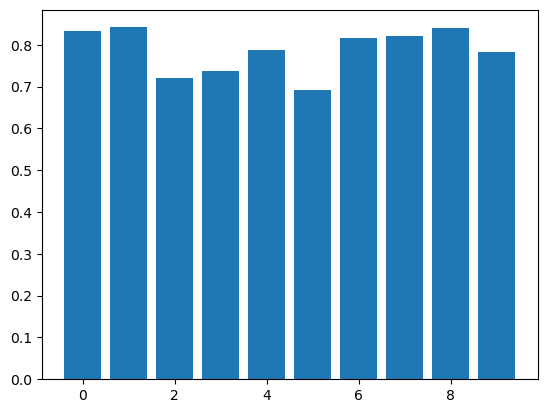

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()